In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.2.2/spark-3.2.2-bin-hadoop2.7.tgz

In [ ]:
!tar -xvf spark-3.2.2-bin-hadoop2.7.tgz

spark-3.2.2-bin-hadoop2.7/
spark-3.2.2-bin-hadoop2.7/RELEASE
spark-3.2.2-bin-hadoop2.7/LICENSE
spark-3.2.2-bin-hadoop2.7/NOTICE
spark-3.2.2-bin-hadoop2.7/README.md
spark-3.2.2-bin-hadoop2.7/jars/
spark-3.2.2-bin-hadoop2.7/jars/HikariCP-2.5.1.jar
spark-3.2.2-bin-hadoop2.7/jars/JLargeArrays-1.5.jar
spark-3.2.2-bin-hadoop2.7/jars/JTransforms-3.1.jar
spark-3.2.2-bin-hadoop2.7/jars/RoaringBitmap-0.9.0.jar
spark-3.2.2-bin-hadoop2.7/jars/ST4-4.0.4.jar
spark-3.2.2-bin-hadoop2.7/jars/activation-1.1.1.jar
spark-3.2.2-bin-hadoop2.7/jars/aircompressor-0.21.jar
spark-3.2.2-bin-hadoop2.7/jars/algebra_2.12-2.0.1.jar
spark-3.2.2-bin-hadoop2.7/jars/annotations-17.0.0.jar
spark-3.2.2-bin-hadoop2.7/jars/antlr-runtime-3.5.2.jar
spark-3.2.2-bin-hadoop2.7/jars/antlr4-runtime-4.8.jar
spark-3.2.2-bin-hadoop2.7/jars/aopalliance-1.0.jar
spark-3.2.2-bin-hadoop2.7/jars/aopalliance-repackaged-2.6.1.jar
spark-3.2.2-bin-hadoop2.7/jars/apacheds-i18n-2.0.0-M15.jar
spark-3.2.2-bin-hadoop2.7/jars/apacheds-kerberos-codec

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
df = spark.read.csv('churn.csv', inferSchema=True, header=True)

In [ ]:
df.show()

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+------------

1. Построить гистограмму количества звонков в техническую поддержку

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
number_of_calls = [v.number_customer_service_calls for v in df[['number_customer_service_calls']].collect()]

(array([1023., 1786., 1127.,  665.,  252.,   96.,   34.,   13.,    2.,
           2.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

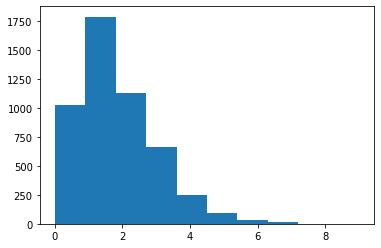

In [ ]:
plt.hist(number_of_calls)

2.Рассчитать и построить гистограмму общей длительности звонков клиента (дневных + ночных + вечерних + международны)

In [ ]:
df = df.withColumn('total_calls', df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + df['total_intl_minutes'])

(array([  10.,   88.,  267.,  784., 1206., 1268.,  864.,  381.,  109.,
          23.]),
 array([284.3 , 344.37, 404.44, 464.51, 524.58, 584.65, 644.72, 704.79,
        764.86, 824.93, 885.  ]),
 <a list of 10 Patch objects>)

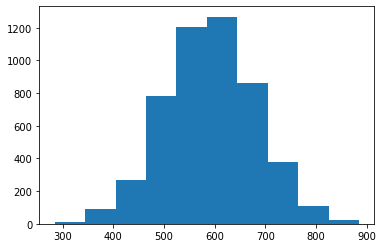

In [ ]:
plt.hist([v.total_calls for v in df[['total_calls']].collect()])

3. Собственноручно (не используя встроенных функций) рассчитать линейный коэффициент корреляции (https://ru.wikipedia.org/wiki/Корреляция) общего количества минут и количества звонков в техподдержку

In [ ]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, sum as _sum, sqrt as _sqrt, pow as _pow, col

In [ ]:
df_stats = df.select(
    _mean(col('total_calls')).alias('mean_calls'),
    _mean(col('number_customer_service_calls')).alias('mean_service')
).collect()

mean_calls = df_stats[0]['mean_calls']
mean_service = df_stats[0]['mean_service']

In [ ]:
df.select( (_sum( (col('total_calls') - mean_calls) * (col('number_customer_service_calls') - mean_service ) ) /  _sqrt( _sum( _pow(col('total_calls') - mean_calls, 2) ) * _sum( _pow(col('number_customer_service_calls') - mean_service, 2) ) )).alias('r')).collect()

[Row(r=-0.01140791082744116)]

4. Визуализировать точечный график по общему количеству минут / количеству звонков в поддержку, подкрасив точки в зависимости от оттока абонента

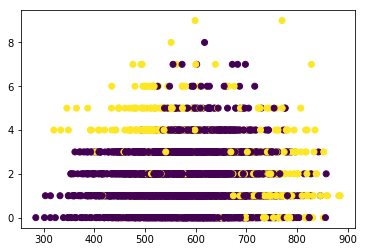

In [ ]:
plt.scatter(
    [v.total_calls for v in df[['total_calls']].collect()],
    number_of_calls,
    c=[v.churned for v in df[['churned']].collect()]
)

5. Вывести top-5 самых много и самых мало говорящих клиентов

In [ ]:
df.orderBy('total_calls', ascending=False).show(5)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+-----------------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|      total_calls|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+--------------

In [ ]:
df.orderBy('total_calls', ascending=True).show(5)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+------------------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|       total_calls|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------

6. Вывести долю оттока клиентов и среднюю стоимость минуты дневного времени разговора  в зависимости от штата

In [ ]:
df.withColumn('churned_int', col('churned').cast('int')).select('state', 'churned_int', 'total_calls').groupby('state').mean().show()

+-----+-------------------+-----------------+
|state|   avg(churned_int)| avg(total_calls)|
+-----+-------------------+-----------------+
|   AZ|0.10112359550561797|574.5539325842693|
|   SC|0.17582417582417584|585.8043956043956|
|   LA|0.08536585365853659|578.0060975609757|
|   MN|               0.16|594.3679999999999|
|   NJ|               0.25|603.5053571428571|
|   DC|0.10227272727272728|591.5863636363634|
|   OR|0.15789473684210525|593.5228070175438|
|   VA|0.05084745762711865|596.0406779661016|
|   RI| 0.0707070707070707| 598.961616161616|
|   WY|0.09565217391304348|590.4217391304346|
|   KY|0.15151515151515152|588.7242424242424|
|   NH|0.12631578947368421|595.5884210526315|
|   MI|0.17475728155339806|584.4815533980579|
|   NV|0.18888888888888888|599.3599999999999|
|   WI|0.07547169811320754|576.6867924528301|
|   ID|0.11764705882352941|589.2739495798318|
|   CA| 0.2692307692307692|577.3076923076924|
|   NE|0.06818181818181818|584.6056818181818|
|   CT|0.16161616161616163|589.428

7. перевести штат в one-hot формат при помощи pandas-функции get_dummies или удалите колонку, если вы делаете решение на pyspark
8. Разбить данные на множество для обучения и для проверки, отобрав признаки для обучения модели классификации (убрать номер телефона, код региона, признаки планов + все добавленные аттрибуты)
9. Привести данные к одному масштабу при помощи StandardScaler в случае Pandas (в случае спарка - не надо)
10. Обучить какую-нибудь модель классификации и оценить качество (точность) на отложенной выборке


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler


label_indexer = StringIndexer(inputCol = 'churned_int', outputCol = 'label')
cols = ['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls']

In [ ]:
assembler = VectorAssembler(

    inputCols = cols,

    outputCol = 'features')

In [ ]:
(train, test) = df.withColumn('churned_int', col('churned').cast('int')).randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml import Pipeline

from pyspark.ml.classification import RandomForestClassifier

classifier = RandomForestClassifier(labelCol = 'label', featuresCol = 'features')

pipeline = Pipeline(stages=[state_indexer, label_indexer, assembler, classifier])

model = pipeline.fit(train)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test)

evaluator = MulticlassClassificationEvaluator()

auroc = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

In [ ]:
auroc

0.89375